# 1. Importing necessary libraries 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import optuna
from lightgbm import LGBMClassifier, early_stopping

# 2. Importing the datasets

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')

In [3]:
train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


# 3. Data Cleaning

In [4]:
train.drop(['id','Product ID'],axis=1,inplace=True)
test.drop(['Product ID'],axis=1,inplace=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Type                     136429 non-null  object 
 1   Air temperature [K]      136429 non-null  float64
 2   Process temperature [K]  136429 non-null  float64
 3   Rotational speed [rpm]   136429 non-null  int64  
 4   Torque [Nm]              136429 non-null  float64
 5   Tool wear [min]          136429 non-null  int64  
 6   Machine failure          136429 non-null  int64  
 7   TWF                      136429 non-null  int64  
 8   HDF                      136429 non-null  int64  
 9   PWF                      136429 non-null  int64  
 10  OSF                      136429 non-null  int64  
 11  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 12.5+ MB


In [6]:
train.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [7]:
test.isna().sum()

id                         0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [8]:
print("Duplicates:",train.duplicated().sum())
train = train.drop_duplicates()

Duplicates: 1156


In [9]:
train.columns = ['Type','Air_Temperature','Process_Temperature',
              'Rotational_Speed','Torque','Tool_Wear','Machine_failure',
              'TWF','HDF','PWF','OSF','RNF']
test.columns = ['id','Type','Air_Temperature','Process_Temperature',
              'Rotational_Speed','Torque','Tool_Wear',
              'TWF','HDF','PWF','OSF','RNF']

# 4. Visualizing Data

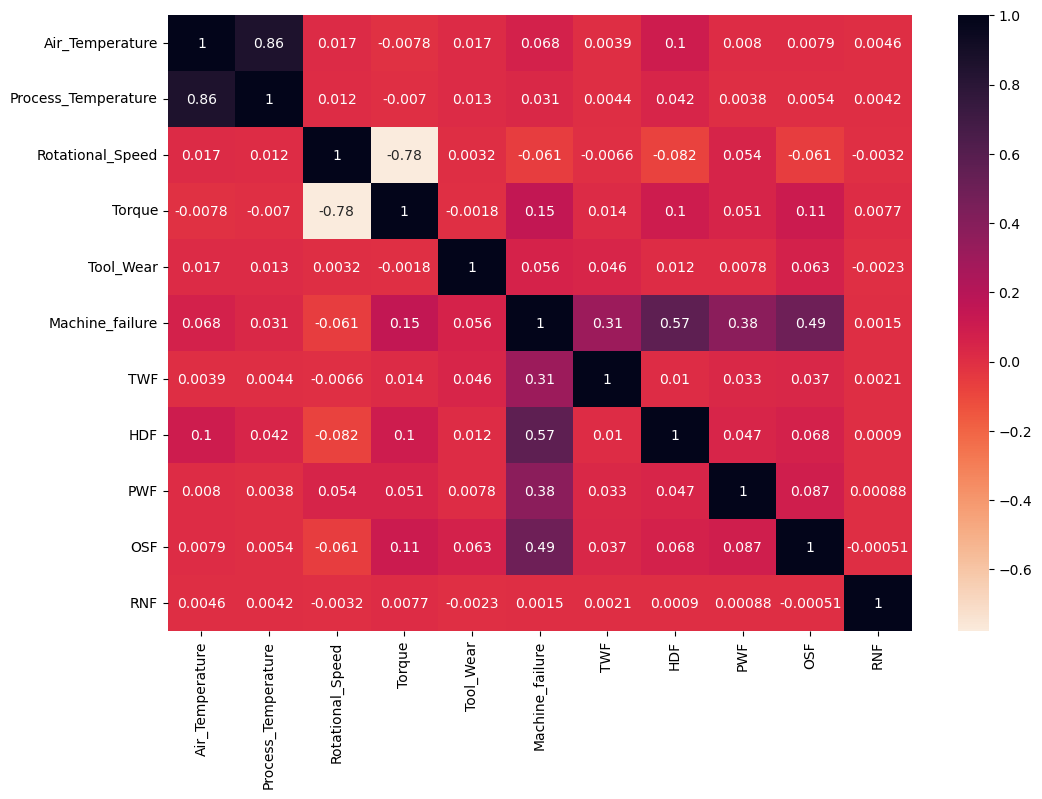

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True,cmap='rocket_r')
plt.show()

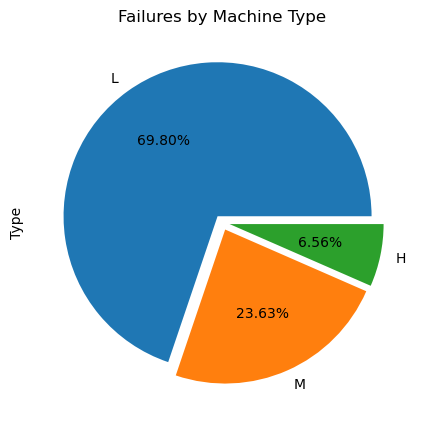

In [11]:
train['Type'].value_counts().plot(kind='pie',
                                  explode=[.05,.05,.05],
                                  autopct='%1.2f%%',
                                  figsize=(8,5))
plt.title('Failures by Machine Type')
plt.show()

# 5. Feature Engineering

In [12]:
def create_features(df):
    df['Failure'] = df[['TWF','HDF','PWF','OSF','RNF']].sum(axis=1)
    df['Power'] = df['Torque']*df['Rotational_Speed']
    df['Temperature_Difference'] = df['Process_Temperature'] - df['Air_Temperature']
    df['Temperature_Ratio'] = df['Air_Temperature'] / df['Process_Temperature']
    df['Torque_to_Speed'] = df['Torque'] / df['Rotational_Speed']
    df['Speed_to_Temp'] = df['Rotational_Speed'] / df['Process_Temperature']
    df['Torque_to_Temp'] = df['Torque'] / df['Process_Temperature']
    df['Power_to_Temp'] = df['Power'] / df['Process_Temperature']
    df['Temperature_Variability'] = df[['Air_Temperature', 'Process_Temperature']].std(axis=1)
    df['Temperature_ChangeRate'] = df['Temperature_Difference'] / df['Tool_Wear']
    df['Temperature_ChangeRate'] = np.where(df['Temperature_ChangeRate']== float('inf'),1, df['Temperature_ChangeRate'])
    df["Torque_WearRatio"] = df['Torque'] / (df['Tool_Wear'] + 0.0001)
    df["Torque_WearProduct"] = df['Torque'] * df['Tool_Wear']
    
    features = ['Air_Temperature', 'Process_Temperature','Rotational_Speed', 'Torque', 'Tool_Wear']    
    for feature in features:
        df[f'{feature}Squared'] = df[feature] ** 2
        df[f'{feature}Cubed'] = df[feature] ** 3
        df[f'{feature}Log'] = df[feature].apply(lambda x: math.log(x) if x > 0 else 0)
    
    for feat1 in features:
        for feat2 in features:
            df[f'{feat1}_{feat2}_Product'] = df[feat1] * df[feat2]
            
    
    return df

In [13]:
train = create_features(train)
test = create_features(test)
train.head()

,Type,Air_Temperature,Process_Temperature,Rotational_Speed,Torque,Tool_Wear,Machine_failure,TWF,HDF,PWF,...,Torque_Air_Temperature_Product,Torque_Process_Temperature_Product,Torque_Rotational_Speed_Product,Torque_Torque_Product,Torque_Tool_Wear_Product,Tool_Wear_Air_Temperature_Product,Tool_Wear_Process_Temperature_Product,Tool_Wear_Rotational_Speed_Product,Tool_Wear_Torque_Product,Tool_Wear_Tool_Wear_Product
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,...,10851.66,11176.56,57615.6,1303.21,5054.0,42084.0,43344.0,223440,5054.0,19600
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,...,8805.66,9082.11,51186.9,846.81,5820.0,60520.0,62420.0,351800,5820.0,40000
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,...,7931.45,8175.25,47832.5,702.25,662.5,7482.5,7712.5,45125,662.5,625
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,...,13334.30,13772.87,67513.2,1962.49,8727.1,59297.0,61247.3,300228,8727.1,38809
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,...,10549.20,10938.60,58091.4,1253.16,1203.6,10132.0,10506.0,55794,1203.6,1156


# 6. Preparing data for model

In [14]:
le = LabelEncoder()
ms = MinMaxScaler()

train['Type'] = le.fit_transform(train['Type'])
test['Type'] = le.fit_transform(test['Type'])

num_cols = test.select_dtypes(include=['int64','float64']).columns.drop(['id','TWF','HDF','PWF','OSF','RNF'])

train[num_cols] = ms.fit_transform(train[num_cols])
test[num_cols] = ms.fit_transform(test[num_cols])

In [15]:
y_train = train['Machine_failure']
x_train = train.drop(['Machine_failure'],axis=1)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size=0.3, random_state=123)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test, test_size=0.5, random_state=123)

# 7. Optuna Hyperparamter Search

In [17]:
def objective(trial):
    n_leaves = trial.suggest_int('num_leaves', 25,100)
    max_depth = trial.suggest_int("max_depth", 1,10)
    n_estimators = trial.suggest_int("n_estimators", 10,2000)
    r_alpha = trial.suggest_int("reg_alpha", 0.0, 0.1)
    r_lambda = trial.suggest_int("reg_lambda", 0.0, 0.1)
    l_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    subsample =  trial.suggest_uniform('subsample', 0.5, 1.0)
    lambda_l1 = trial.suggest_int("lambda_l1", 0.0, 4)
    lambda_l2 = trial.suggest_int("lambda_l2", 0.0, 4)
    feature_fraction =  trial.suggest_uniform('feature_fraction', 0.5, 1.0)

    lgb = LGBMClassifier(
            num_leaves =n_leaves,
            max_depth=max_depth, 
            n_estimators=n_estimators,
            reg_alpha = r_alpha,
            reg_lambda = r_lambda,
            learning_rate = l_rate,
            subsample = subsample,
            lambda_l1 = lambda_l1,
            lambda_l2 = lambda_l2,
            feature_fraction = feature_fraction
        )
    
    lgb.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=20, verbose=False)

    y_pred_proba = lgb.predict_proba(x_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    return roc_auc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2023-06-26 16:33:52,688] A new study created in memory with name: no-name-a3ad5bf3-61d6-461e-b564-14eb660b8d99


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.8225002760452609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8225002760452609
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0 will be ignored. Current value: lambda_l2=1


[I 2023-06-26 16:34:09,745] Trial 0 finished with value: 0.9673831846124077 and parameters: {'num_leaves': 48, 'max_depth': 7, 'n_estimators': 1567, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.008411829387129475, 'subsample': 0.6389165106099335, 'lambda_l1': 0, 'lambda_l2': 1, 'feature_fraction': 0.8225002760452609}. Best is trial 0 with value: 0.9673831846124077.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.6888384624646251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6888384624646251
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0 will be ignored. Current value: lambda_l2=3


[I 2023-06-26 16:34:12,571] Trial 1 finished with value: 0.9674234192664921 and parameters: {'num_leaves': 94, 'max_depth': 5, 'n_estimators': 1177, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.06921489702883656, 'subsample': 0.6235505129630725, 'lambda_l1': 0, 'lambda_l2': 3, 'feature_fraction': 0.6888384624646251}. Best is trial 1 with value: 0.9674234192664921.


[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.6181776219387167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181776219387167
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0 will be ignored. Current value: lambda_l2=3


[I 2023-06-26 16:34:22,832] Trial 2 finished with value: 0.9613705458144797 and parameters: {'num_leaves': 57, 'max_depth': 1, 'n_estimators': 1122, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.013311857448118289, 'subsample': 0.9890010727472418, 'lambda_l1': 3, 'lambda_l2': 3, 'feature_fraction': 0.6181776219387167}. Best is trial 1 with value: 0.9674234192664921.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.5650221381071393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650221381071393
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0 will be ignored. Current value: lambda_l2=1


[I 2023-06-26 16:34:24,217] Trial 3 finished with value: 0.9620532945592205 and parameters: {'num_leaves': 87, 'max_depth': 3, 'n_estimators': 77, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.03724242367189369, 'subsample': 0.6100950022359113, 'lambda_l1': 0, 'lambda_l2': 1, 'feature_fraction': 0.5650221381071393}. Best is trial 1 with value: 0.9674234192664921.


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.8863104571755187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8863104571755187
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0


[I 2023-06-26 16:34:28,124] Trial 4 finished with value: 0.9685262674148607 and parameters: {'num_leaves': 96, 'max_depth': 6, 'n_estimators': 551, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.07589836274237408, 'subsample': 0.6883031029799151, 'lambda_l1': 1, 'lambda_l2': 0, 'feature_fraction': 0.8863104571755187}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.773865546843318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.773865546843318
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0


[I 2023-06-26 16:34:31,738] Trial 5 finished with value: 0.9669254088274986 and parameters: {'num_leaves': 42, 'max_depth': 2, 'n_estimators': 946, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.06661765946625801, 'subsample': 0.8517350879979957, 'lambda_l1': 2, 'lambda_l2': 0, 'feature_fraction': 0.773865546843318}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.6878659833891239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6878659833891239
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0 will be ignored. Current value: lambda_l2=4


[I 2023-06-26 16:34:48,388] Trial 6 finished with value: 0.9644551251041915 and parameters: {'num_leaves': 94, 'max_depth': 1, 'n_estimators': 1882, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.010987951351203635, 'subsample': 0.8715925770423454, 'lambda_l1': 0, 'lambda_l2': 4, 'feature_fraction': 0.6878659833891239}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] feature_fraction is set=0.9383273117840321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9383273117840321
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0 will be ignored. Current value: lambda_l2=3


[I 2023-06-26 16:34:57,299] Trial 7 finished with value: 0.9574512718802097 and parameters: {'num_leaves': 28, 'max_depth': 2, 'n_estimators': 662, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.005478459869437744, 'subsample': 0.5340704568419508, 'lambda_l1': 4, 'lambda_l2': 3, 'feature_fraction': 0.9383273117840321}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] feature_fraction is set=0.6395803982729762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6395803982729762
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0 will be ignored. Current value: lambda_l2=4


[I 2023-06-26 16:35:01,867] Trial 8 finished with value: 0.9582616241714297 and parameters: {'num_leaves': 96, 'max_depth': 4, 'n_estimators': 323, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.0017601885947582923, 'subsample': 0.5444504503310782, 'lambda_l1': 4, 'lambda_l2': 4, 'feature_fraction': 0.6395803982729762}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.6842656791064706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6842656791064706
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0 will be ignored. Current value: lambda_l2=1


[I 2023-06-26 16:35:06,786] Trial 9 finished with value: 0.9685054911387633 and parameters: {'num_leaves': 78, 'max_depth': 8, 'n_estimators': 417, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.0648243269672602, 'subsample': 0.5936826706685098, 'lambda_l1': 3, 'lambda_l2': 1, 'feature_fraction': 0.6842656791064706}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9809173564081451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9809173564081451
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0


[I 2023-06-26 16:35:15,662] Trial 10 finished with value: 0.9670661913550844 and parameters: {'num_leaves': 73, 'max_depth': 10, 'n_estimators': 752, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.029185571033120652, 'subsample': 0.7088632920630991, 'lambda_l1': 1, 'lambda_l2': 0, 'feature_fraction': 0.9809173564081451}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.839885048133779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.839885048133779
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0 will be ignored. Current value: lambda_l2=1


[I 2023-06-26 16:35:19,578] Trial 11 finished with value: 0.9680200394935302 and parameters: {'num_leaves': 76, 'max_depth': 8, 'n_estimators': 454, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.09914346284127086, 'subsample': 0.7314833625975209, 'lambda_l1': 2, 'lambda_l2': 1, 'feature_fraction': 0.839885048133779}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.8902823129234119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8902823129234119
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0 will be ignored. Current value: lambda_l2=0


[I 2023-06-26 16:35:24,096] Trial 12 finished with value: 0.9637179549198222 and parameters: {'num_leaves': 79, 'max_depth': 7, 'n_estimators': 95, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.029966136557861976, 'subsample': 0.5005854387154276, 'lambda_l1': 3, 'lambda_l2': 0, 'feature_fraction': 0.8902823129234119}. Best is trial 4 with value: 0.9685262674148607.


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5220878263992628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5220878263992628
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:35:27,454] Trial 13 finished with value: 0.9696641561482892 and parameters: {'num_leaves': 63, 'max_depth': 9, 'n_estimators': 450, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.08953967599799513, 'subsample': 0.6846717797601702, 'lambda_l1': 1, 'lambda_l2': 2, 'feature_fraction': 0.5220878263992628}. Best is trial 13 with value: 0.9696641561482892.


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.749365806554507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.749365806554507
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:35:30,655] Trial 14 finished with value: 0.9659479160464792 and parameters: {'num_leaves': 64, 'max_depth': 10, 'n_estimators': 732, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.09758527706773004, 'subsample': 0.6908837251447083, 'lambda_l1': 1, 'lambda_l2': 2, 'feature_fraction': 0.749365806554507}. Best is trial 13 with value: 0.9696641561482892.


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5554284781967171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5554284781967171
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:35:34,358] Trial 15 finished with value: 0.9685334770927603 and parameters: {'num_leaves': 61, 'max_depth': 6, 'n_estimators': 1375, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.04162402425037612, 'subsample': 0.7775481516428421, 'lambda_l1': 1, 'lambda_l2': 2, 'feature_fraction': 0.5554284781967171}. Best is trial 13 with value: 0.9696641561482892.


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.510862048229996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510862048229996
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:35:40,699] Trial 16 finished with value: 0.970176120802572 and parameters: {'num_leaves': 61, 'max_depth': 9, 'n_estimators': 1496, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.03923399127175255, 'subsample': 0.7678541169347383, 'lambda_l1': 1, 'lambda_l2': 2, 'feature_fraction': 0.510862048229996}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.5038649873900582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5038649873900582
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:35:52,635] Trial 17 finished with value: 0.9697173372132255 and parameters: {'num_leaves': 49, 'max_depth': 9, 'n_estimators': 1978, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.022492575783123237, 'subsample': 0.7776585640138005, 'lambda_l1': 2, 'lambda_l2': 2, 'feature_fraction': 0.5038649873900582}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.5024883925271587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5024883925271587
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:36:06,301] Trial 18 finished with value: 0.969834552621656 and parameters: {'num_leaves': 43, 'max_depth': 9, 'n_estimators': 1943, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.018797893840909158, 'subsample': 0.7728491495734892, 'lambda_l1': 2, 'lambda_l2': 2, 'feature_fraction': 0.5024883925271587}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.5877966665902037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877966665902037
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0 will be ignored. Current value: lambda_l2=3


[I 2023-06-26 16:36:16,647] Trial 19 finished with value: 0.9675041211449156 and parameters: {'num_leaves': 32, 'max_depth': 9, 'n_estimators': 1697, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.018457203700459317, 'subsample': 0.8168403256485186, 'lambda_l1': 2, 'lambda_l2': 3, 'feature_fraction': 0.5877966665902037}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.5012572911404616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5012572911404616
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0 will be ignored. Current value: lambda_l2=3


[I 2023-06-26 16:36:29,278] Trial 20 finished with value: 0.9692041321842503 and parameters: {'num_leaves': 39, 'max_depth': 8, 'n_estimators': 1684, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.01754983440362458, 'subsample': 0.7545675452557041, 'lambda_l1': 2, 'lambda_l2': 3, 'feature_fraction': 0.5012572911404616}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.5003673844461529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003673844461529
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:36:38,939] Trial 21 finished with value: 0.9695087992180678 and parameters: {'num_leaves': 51, 'max_depth': 9, 'n_estimators': 1999, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.02398413758022447, 'subsample': 0.7851788055624307, 'lambda_l1': 2, 'lambda_l2': 2, 'feature_fraction': 0.5003673844461529}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.5482056260658841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5482056260658841
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:36:44,025] Trial 22 finished with value: 0.9687585275760102 and parameters: {'num_leaves': 51, 'max_depth': 10, 'n_estimators': 1478, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.04525895415997396, 'subsample': 0.8174468423981717, 'lambda_l1': 3, 'lambda_l2': 2, 'feature_fraction': 0.5482056260658841}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5367205454619361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5367205454619361
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0 will be ignored. Current value: lambda_l2=1


[I 2023-06-26 16:36:52,027] Trial 23 finished with value: 0.969472673305152 and parameters: {'num_leaves': 39, 'max_depth': 9, 'n_estimators': 1875, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.021177059526408224, 'subsample': 0.7502175723425696, 'lambda_l1': 1, 'lambda_l2': 1, 'feature_fraction': 0.5367205454619361}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.5969251834505905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5969251834505905
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:36:56,908] Trial 24 finished with value: 0.9677428157497816 and parameters: {'num_leaves': 46, 'max_depth': 7, 'n_estimators': 1332, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.04584669912259791, 'subsample': 0.8824918714275543, 'lambda_l1': 2, 'lambda_l2': 2, 'feature_fraction': 0.5969251834505905}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.5050162651722914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5050162651722914
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:37:09,567] Trial 25 finished with value: 0.9686495296499167 and parameters: {'num_leaves': 56, 'max_depth': 8, 'n_estimators': 1774, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.014988317114718045, 'subsample': 0.7316730570205456, 'lambda_l1': 3, 'lambda_l2': 2, 'feature_fraction': 0.5050162651722914}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5687941884905224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5687941884905224
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0 will be ignored. Current value: lambda_l2=3


[I 2023-06-26 16:37:19,280] Trial 26 finished with value: 0.9686999198717947 and parameters: {'num_leaves': 71, 'max_depth': 10, 'n_estimators': 1931, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.02640629383369915, 'subsample': 0.8123943923027036, 'lambda_l1': 1, 'lambda_l2': 3, 'feature_fraction': 0.5687941884905224}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.5507182993165575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5507182993165575
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0 will be ignored. Current value: lambda_l2=1


[I 2023-06-26 16:37:34,848] Trial 27 finished with value: 0.9682205925766056 and parameters: {'num_leaves': 34, 'max_depth': 5, 'n_estimators': 1580, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.00943581760177875, 'subsample': 0.6596575530318654, 'lambda_l1': 2, 'lambda_l2': 1, 'feature_fraction': 0.5507182993165575}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] feature_fraction is set=0.6059507083610602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6059507083610602
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


[I 2023-06-26 16:37:48,186] Trial 28 finished with value: 0.9687568220608082 and parameters: {'num_leaves': 68, 'max_depth': 9, 'n_estimators': 1796, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.020832669541549286, 'subsample': 0.7184828226909189, 'lambda_l1': 2, 'lambda_l2': 2, 'feature_fraction': 0.6059507083610602}. Best is trial 16 with value: 0.970176120802572.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.532689464143632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.532689464143632
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0 will be ignored. Current value: lambda_l2=1


[I 2023-06-26 16:38:11,019] Trial 29 finished with value: 0.9690055171866319 and parameters: {'num_leaves': 46, 'max_depth': 7, 'n_estimators': 1536, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.00576029959619465, 'subsample': 0.6500503128947913, 'lambda_l1': 0, 'lambda_l2': 1, 'feature_fraction': 0.532689464143632}. Best is trial 16 with value: 0.970176120802572.


In [18]:
trial = study.best_trial
print('ROC_AUC Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

ROC_AUC Score: 0.970176120802572
Best hyperparameters: {'num_leaves': 61, 'max_depth': 9, 'n_estimators': 1496, 'reg_alpha': 0, 'reg_lambda': 0, 'learning_rate': 0.03923399127175255, 'subsample': 0.7678541169347383, 'lambda_l1': 1, 'lambda_l2': 2, 'feature_fraction': 0.510862048229996}


In [19]:
optuna.visualization.plot_optimization_history(study)

# 8. Model Training

In [20]:
lgbm = LGBMClassifier(**trial.params)
lgbm.fit(x_train,y_train)

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.510862048229996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510862048229996
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0 will be ignored. Current value: lambda_l2=2


LGBMClassifier(feature_fraction=0.510862048229996, lambda_l1=1, lambda_l2=2,
               learning_rate=0.03923399127175255, max_depth=9,
               n_estimators=1496, num_leaves=61, reg_alpha=0, reg_lambda=0,
               subsample=0.7678541169347383)

# 9. Making Predictions

In [21]:
pred = lgbm.predict_proba(test.drop('id',axis=1))

# 10. Submission

In [22]:
submission = pd.DataFrame(test['id'])
submission['Machine failure'] = pred[:,1]
submission

,id,Machine failure
0,136429,0.002531
1,136430,0.001904
2,136431,0.000135
3,136432,0.000155
4,136433,0.000229
...,...,...
90949,227378,0.000534
90950,227379,0.000207
90951,227380,0.000202
90952,227381,0.000030


In [23]:
submission.to_csv('submission.csv',index=False)